In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import fcwt

In [2]:
def fcwtplotter(audio_data,sample_rate,f0,f1):
    #make sure signal is a numpy float array
    audio_data = np.array(audio_data, dtype=np.float32)
    audio_data -= np.mean(audio_data)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        signal = audio_data / max_val


    fn = 100

    fcwt.plot(signal, sample_rate, f0=f0, f1=f1, fn=fn)


In [136]:
# old functions coherence and plotter
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
# Compute the wavelet coherence
def wavelet_coherence_old(signal1,signal2,highest,lowest,nfreqs):
    frame_rate = 360
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2]

def coherence_plot_old(coherence,freqs,rate):
    extent=[0, len(coherence),len(freqs) ,0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
        
    if True:
        plt.figure(figsize=(10,6))
        plt.imshow(coherence, aspect='auto',extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values],fontsize = 14)
        plt.xticks(np.linspace(0, len(coherence), 5),fontsize = 14)

        plt.ylabel('Scale (Frequency)',fontsize = 18)
        plt.xlabel('Time (Days)',fontsize = 18)
        plt.title(f'Wavelet Coherence Between signal1 and signal2',fontsize=20)
        plt.show()


In [91]:
# pull data from polygon
import datetime
import numpy as np
from scipy.signal import detrend
import requests

def pull_data(ticker, api_key):
    """
    Pull and detrend stock data from the past 5 hours using Polygon.io.

    Parameters:
    ticker (str): Stock ticker symbol.
    api_key (str): Your Polygon.io API key.

    Returns:
    times (array): Array of timestamps.
    close (array): Closing prices.
    detrended_close (array): Detrended closing prices.
    stock_data (DataFrame): Raw stock data from Polygon.
    """
    # Define the date range
    end_datetime = datetime.datetime(2025, 2, 12, 16)
    start_datetime = end_datetime - datetime.timedelta(days=360)

    # Convert to timestamp format for Polygon API
    start_timestamp = int(start_datetime.timestamp()) * 1000
    end_timestamp = int(end_datetime.timestamp()) * 1000

    # Polygon API endpoint for aggregate bars
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_datetime.date()}/{end_datetime.date()}?adjusted=true&apiKey={api_key}"
    
    # Fetch the data
    response = requests.get(url)
    data = response.json()

    if 'results' not in data:
        raise ValueError(f"Error fetching data: {data}")

    # Convert data to arrays
    times = np.array([entry['t'] for entry in data['results']])  # Timestamps
    close = np.array([entry['c'] for entry in data['results']])  # Closing prices

    # Detrend closing prices
    detrended_close = detrend(close)

    return times, close, detrended_close, data


In [116]:
# Example usage:
key = 'jjeryxeZXNkBhTEQF0SDj8uBBI_N1dBM'	
ticker = 'AAPL'
_,close,detrended,df= pull_data(ticker,key)
_,close2,detrended2,df2= pull_data('AMZN',key)

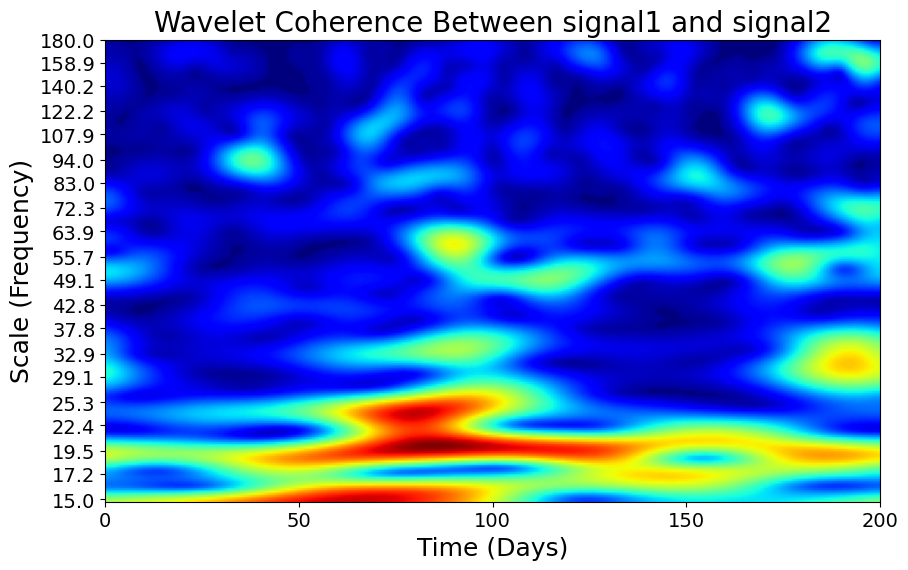

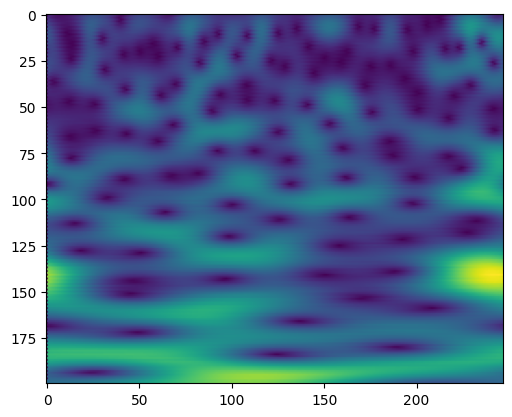

In [137]:
coh,freqs,coeffs = wavelet_coherence_old(detrended,detrended2,180,15,200)
coherence_plot_old(coh,freqs,360)
plt.imshow(np.abs(coeffs[0]))